## Transfer learning with DenseNet

In [1]:
# Downloading raw data required for training 

!gdown https://drive.google.com/uc?id=1E6LIfRf3UDcIDCgl8ZBI2j0odmvS5c-w

Downloading...
From: https://drive.google.com/uc?id=1E6LIfRf3UDcIDCgl8ZBI2j0odmvS5c-w
To: /content/kaggle_transfer_learning_covid.zip
105MB [00:01, 86.6MB/s] 


In [2]:
# Unzip the the file on the local instance

!unzip -qq kaggle_transfer_learning_covid.zip

In [38]:
# Import the necessary libraries
import os
import cv2 as cv
import pathlib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()

In [5]:
# Path of the dataset
data_path = '/content/kaggle_transfer_learning_covid/'
train_dir = os.path.join(data_path,'train')
test_dir = os.path.join(data_path, 'test')


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.applications import DenseNet201

In [7]:
# Get your train and test data
train_datagen=ImageDataGenerator(rotation_range=20,width_shift_range=0.3,height_shift_range=0.3,shear_range=0.2,preprocessing_function=preprocess_input,validation_split=0.1,horizontal_flip=True,vertical_flip=True,zoom_range=0.2)
train_generator=train_datagen.flow_from_directory(train_dir,target_size=(224,224),class_mode='categorical',subset='training',shuffle=True)
val_generator=train_datagen.flow_from_directory(train_dir,target_size=(224,224),class_mode='categorical',subset='validation',batch_size=3,shuffle=True)

Found 189 images belonging to 3 classes.
Found 21 images belonging to 3 classes.


In [8]:
base_model=DenseNet201(input_shape=[224,224,3],weights='imagenet',include_top=False) 

74842112/74836368 [==============================] - 1s 0us/step


In [54]:
x=base_model.output
base_model.trainable=False
x1=keras.layers.GlobalAveragePooling2D()(x)
x2=keras.layers.Dense(512,activation='relu')(x1)
preds=keras.layers.Dense(3,activation='softmax')(x2) 
DenseNet=keras.models.Model(inputs=[base_model.input],outputs=[preds]) #specify the inputs and outputs

In [55]:
DenseNet.compile(loss='categorical_crossentropy',optimizer=keras.optimizers.Adam(lr=0.001),metrics=['accuracy'])

In [56]:
step_size_train=train_generator.n//train_generator.batch_size
step_size_validation=val_generator.n//val_generator.batch_size 

history=DenseNet.fit(train_generator,validation_data=val_generator,steps_per_epoch=step_size_train,validation_steps=step_size_validation,initial_epoch=0,epochs=20)

Epoch 1/20
5/5 [==============================] - 16s 2s/step - loss: 1.8801 - accuracy: 0.3667 - val_loss: 1.5151 - val_accuracy: 0.5714
Epoch 2/20
5/5 [==============================] - 6s 1s/step - loss: 0.7302 - accuracy: 0.6931 - val_loss: 0.3401 - val_accuracy: 0.9048
Epoch 3/20
5/5 [==============================] - 6s 1s/step - loss: 0.6432 - accuracy: 0.6759 - val_loss: 0.3870 - val_accuracy: 0.8571
Epoch 4/20
5/5 [==============================] - 6s 1s/step - loss: 0.2854 - accuracy: 0.8931 - val_loss: 0.1538 - val_accuracy: 1.0000
Epoch 5/20
5/5 [==============================] - 6s 1s/step - loss: 0.1481 - accuracy: 0.9391 - val_loss: 0.1997 - val_accuracy: 0.9524
Epoch 6/20
5/5 [==============================] - 6s 1s/step - loss: 0.2878 - accuracy: 0.8908 - val_loss: 0.1599 - val_accuracy: 0.9524
Epoch 7/20
5/5 [==============================] - 6s 1s/step - loss: 0.1450 - accuracy: 0.9217 - val_loss: 0.1232 - val_accuracy: 0.9524
Epoch 8/20
5/5 [========================

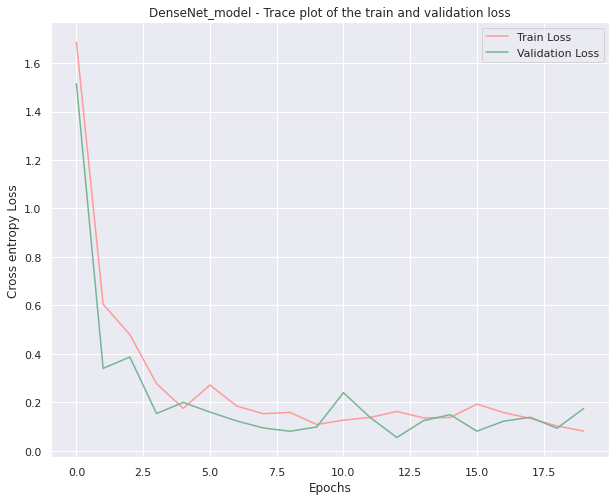

In [57]:
# Plot the Error of the model
plt.rcParams["figure.figsize"] = (10,8)
plt.title("DenseNet_model - Trace plot of the train and validation loss")
plt.plot(history.history['loss'], label='Train Loss', color='#FF9A98')
plt.plot(history.history['val_loss'],  label='Validation Loss', color='#75B594')
plt.legend()

# Set the axes labels
plt.xlabel('Epochs')
plt.ylabel('Cross entropy Loss')
plt.legend()
plt.show()

In [58]:
labels=np.array([0.,0.,0.,0.,0.,0.,0.,1.,1.,1.,1.,1.,1.,1.,2.,2.,2.,2.,2.,2.,2.,])
val_generator_shuffle=train_datagen.flow_from_directory(train_dir,target_size=(224,224),class_mode='categorical',subset='validation',batch_size=3,shuffle=False)
val_prob=DenseNet.predict(val_generator_shuffle,steps=step_size_validation)
val_pred=np.argmax(val_prob,axis=1)

Found 21 images belonging to 3 classes.


In [59]:
from sklearn import metrics
print(metrics.classification_report(labels,val_pred,digits=3))

              precision    recall  f1-score   support

         0.0      1.000     1.000     1.000         7
         1.0      1.000     0.857     0.923         7
         2.0      0.875     1.000     0.933         7

    accuracy                          0.952        21
   macro avg      0.958     0.952     0.952        21
weighted avg      0.958     0.952     0.952        21



### Confusion matrix

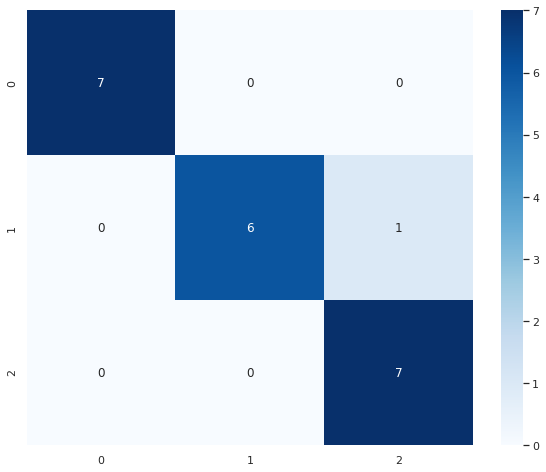

In [60]:
cm=metrics.confusion_matrix(labels,val_pred)
sns.heatmap(cm,annot=True,cmap='Blues')

### ROC curves

In [61]:
from sklearn.preprocessing import label_binarize
y_true = label_binarize(labels,classes=[0,1,2])

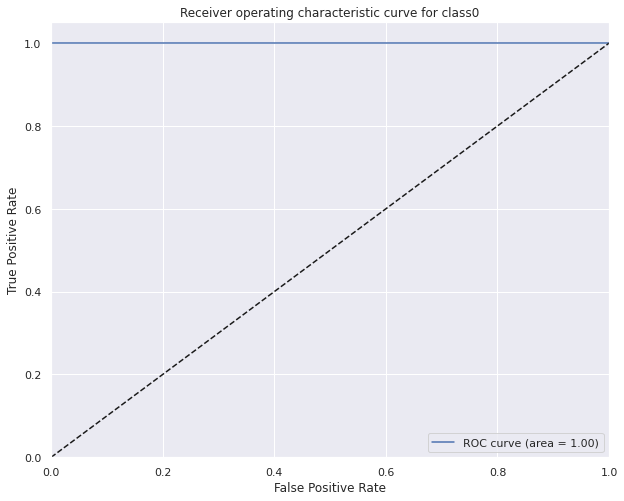

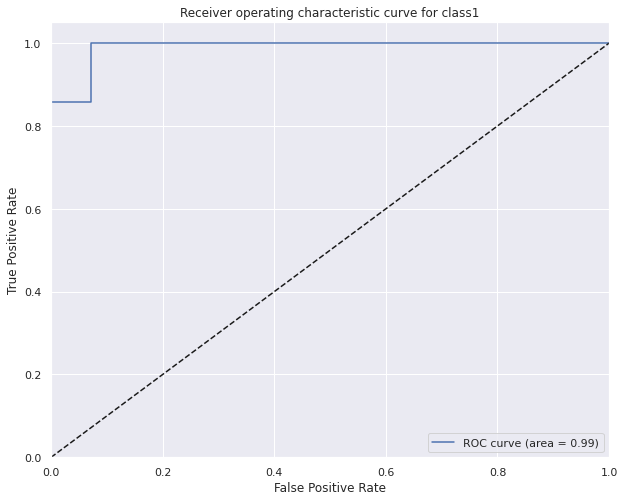

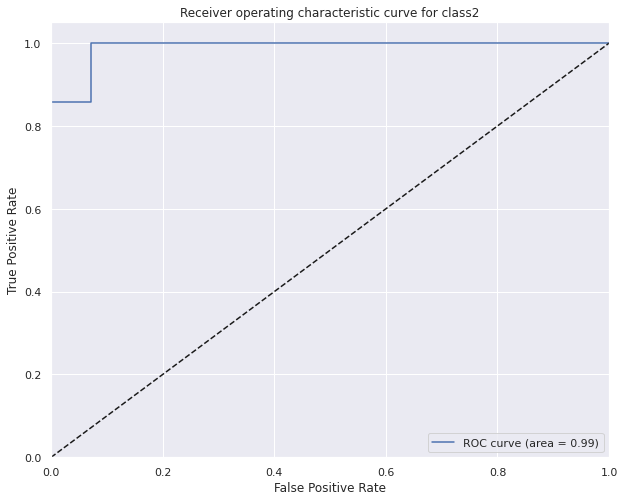

In [62]:
n_classes = 3
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = metrics.roc_curve(y_true[:, i], val_prob[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic curve for class'+str(i))
    plt.legend(loc="lower right")
    plt.show()

### Precision-Recall curves

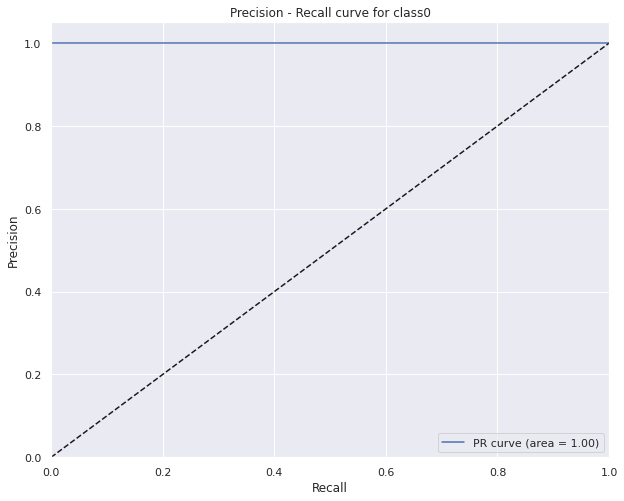

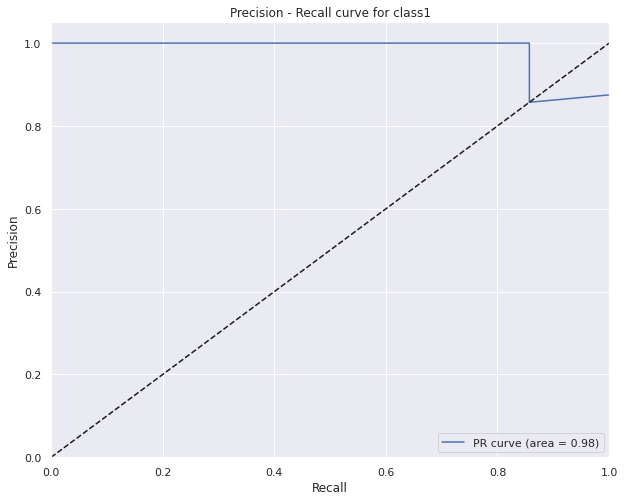

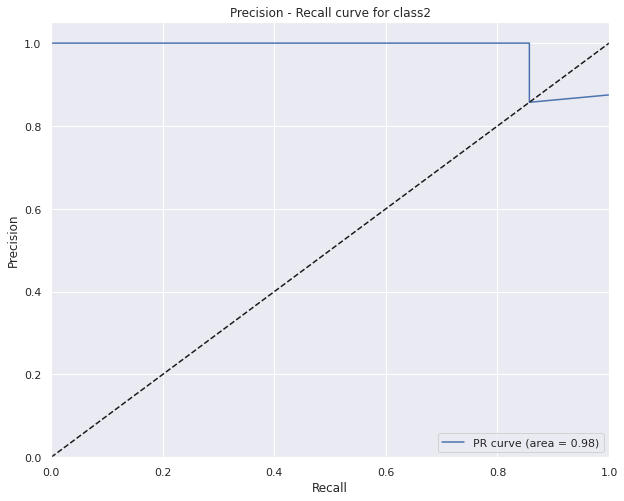

In [63]:
# precision recall curve
precision = dict()
recall = dict()
pr_auc = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = metrics.precision_recall_curve(y_true[:, i],val_prob[:, i])
    pr_auc[i] = metrics.auc(recall[i], precision[i])

# Plot of a PR curve for a specific class
for i in range(n_classes):
    plt.figure()
    plt.plot(recall[i], precision[i], label='PR curve (area = %0.2f)' % pr_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision - Recall curve for class'+str(i))
    plt.legend(loc="lower right")
    plt.show()

### Saving the weights

In [68]:
weightsAndBiases_1 = DenseNet.layers[-1].get_weights()
weightsAndBiases_2 = DenseNet.layers[-2].get_weights()

In [70]:
import pickle
with open("x2.txt", "wb") as fp:
  pickle.dump(weightsAndBiases_2, fp)
with open("pred.txt", "wb") as fp:
  pickle.dump(weightsAndBiases_1, fp)